## Load libraries

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import polars as pl
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap


## ESM pathogenicity prediction

In [ ]:
!python3 ./../z.others/esm-variants/esm_score_missense_mutations.py --input-fasta-file ./../data/egfr.fasta --output-csv-file ./../predictions/output.csv

Using GPU.
Loading the model (esm1b_t33_650M_UR50S)...
Downloading: "https://github.com/facebookresearch/esm/zipball/main" to /home/crowfoot2/.cache/torch/hub/main.zip
Downloading: "https://dl.fbaipublicfiles.com/fair-esm/models/esm1b_t33_650M_UR50S.pt" to /home/crowfoot2/.cache/torch/hub/checkpoints/esm1b_t33_650M_UR50S.pt
Downloading: "https://dl.fbaipublicfiles.com/fair-esm/regression/esm1b_t33_650M_UR50S-contact-regression.pt" to /home/crowfoot2/.cache/torch/hub/checkpoints/esm1b_t33_650M_UR50S-contact-regression.pt
Invoking the model...
100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  1.91it/s]
Saving results...
Done.


Heatmap  visualization

In [3]:
df = pl.read_csv("../predictions/output.csv")
df


seq_id,mut_name,esm_score
str,str,f64
"""sp|P00533|EGFR_HUMAN""","""M1K""",-9.265383
"""sp|P00533|EGFR_HUMAN""","""M1R""",-6.815847
"""sp|P00533|EGFR_HUMAN""","""M1H""",-9.179767
"""sp|P00533|EGFR_HUMAN""","""M1E""",-8.711465
"""sp|P00533|EGFR_HUMAN""","""M1D""",-10.016198
…,…,…
"""sp|P00533|EGFR_HUMAN""","""A1210M""",-3.607732
"""sp|P00533|EGFR_HUMAN""","""A1210P""",-3.11766
"""sp|P00533|EGFR_HUMAN""","""A1210Y""",-3.523082


In [4]:
df_tidy = (df
      .with_columns([
          #pl.col("mut_name").str.extract(r"^(\w)", 1).alias("wt_aa"),  # Wild-type amino acid
          pl.col("mut_name").str.extract(r"(\d+)", 1).cast(pl.Int64).alias("aa_pos"),  # Amino acid position
          pl.col("mut_name").str.extract(r"(\w)$", 1).alias("mut_aa")
          ])  # Mutant amino acid
      .drop(["seq_id", "mut_name"]) 
      .pivot(
          values="esm_score",
          index="mut_aa",
          on="aa_pos"
          )
)
df_tidy

mut_aa,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,…,1174,1175,1176,1177,1178,1179,1180,1181,1182,1183,1184,1185,1186,1187,1188,1189,1190,1191,1192,1193,1194,1195,1196,1197,1198,1199,1200,1201,1202,1203,1204,1205,1206,1207,1208,1209,1210
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""K""",-9.265383,-6.314134,-6.76234,-6.460599,-7.56495,-5.136602,-7.126701,-6.762394,-8.332967,-9.699649,-13.433224,-15.692764,-14.647596,-16.953785,-15.900531,-13.762552,-12.641475,-12.874136,-9.893444,-8.271677,-8.840784,-10.236034,-7.86914,-9.361956,-5.833891,-5.407037,-7.428503,0.0,0.0,-12.522585,-15.082812,-2.146318,-13.993549,-13.235525,-7.15701,-10.502773,…,-3.321559,-4.522663,-4.050119,-3.697246,-4.303129,0.0,-3.638642,-2.904,0.0,-3.69341,-3.145259,-5.421525,-3.670834,-3.321979,0.0,-3.517388,-4.284222,-4.118806,-4.398833,-5.430156,-6.850603,-5.214496,-7.704044,-9.223727,-5.539832,-2.790908,-3.683733,-3.378412,-4.705294,-3.428854,-3.67885,-3.808302,-3.618536,-2.423924,-2.322779,-2.758082,-2.813704
"""R""",-6.815847,0.0,-3.204238,-1.57427,-2.990319,-0.972012,-3.342695,-2.673665,-3.98015,-5.880919,-9.061934,-10.307349,-10.350126,-12.771907,-11.356608,-9.530105,-8.792726,-7.654113,-5.4185,-4.4323,-3.881929,-5.292734,0.0,-6.700838,-5.670397,-5.508701,-7.959338,-3.646641,-4.130662,-12.498556,-13.512222,-3.235459,-12.656055,-13.768642,-7.674609,-11.000875,…,-3.563887,-4.341669,-3.567158,-3.674052,-4.477247,-3.665032,-4.298983,-3.23107,-4.300479,-4.170585,-3.382784,-5.02848,-3.782517,-3.103957,-3.256016,-3.733613,-4.686317,-4.11828,-4.574374,-5.477048,-7.268837,-4.688017,-8.288779,-9.008012,-5.245646,0.0,-3.668751,-3.849176,-4.991415,-3.514811,-4.360566,-3.776345,-3.467644,-2.728398,-2.233164,-3.06704,-3.00548
"""H""",-9.179767,-7.693071,-6.450239,-5.026602,-6.192924,-4.787275,-6.835737,-6.226599,-7.965634,-9.129643,-12.559818,-12.551565,-11.432951,-14.255153,-12.095516,-9.755909,-8.988108,-8.501269,-5.948933,-5.424528,-6.436499,-6.469124,-5.896893,-8.076064,-6.192335,-5.02344,-7.168701,-3.39633,-6.16952,-12.467144,-14.045536,-4.813924,-14.664292,-14.948286,-5.829158,-9.127102,…,-4.102826,-3.97506,-4.008079,-3.9112,-5.03177,-4.670332,-4.887461,-4.557251,-4.440238,-4.993371,-4.295406,-5.093728,-3.026539,-3.281294,-3.512721,-3.967661,-4.788045,-4.500393,-4.977956,-5.649982,-7.030916,-4.81255,-7.770657,-8.431276,-5.407562,-2.813736,-4.075278,-3.974371,-5.306602,-4.077664,-4.531793,-5.157532,-3.211103,-3.304093,-2.853361,-4.043706,-3.613025
"""E""",-8.711465,-6.170656,-6.887229,-5.227186,-6.619214,-5.321899,-7.320318,-7.098025,-9.396008,-9.48491,-13.299267,-15.103544,-13.010261,-15.723927,-13.955763,-11.275921,-10.210773,-11.184254,-6.829081,-5.44969,-6.008268,-6.348301,-5.841083,-7.091326,-4.608987,0.0,0.0,-3.558286,-5.078988,-11.583942,-14.2942,-4.405995,-11.714785,-14.670615,-4.608013,-11.382919,…,-3.358039,-3.716305,-3.574647,-3.620033,-5.017842,-2.761757,0.0,-3.245817,-3.675119,-3.47259,-3.723922,-5.772632,-3.736708,-3.917613,-3.653039,-3.775594,-4.575384,-3.795437,-3.992529,0.0,-6.141532,-5.093587,0.0,-9.083805,-4.777628,-2.258119,-2.477544,-3.423388,-3.762572,-2.471091,-3.58213,-4.014785,0.0,-1.970665,-2.463813,-2.502773,-3.876632
"""D""",-10.016198,-8.169365,-7.119099,-6.488449,-7.266741,-6.053151,-8.651999,-8.201175,-11.165211,-12.628575,-15.977899,-17.126518,-15.955228,-18.016248,-15.865956,-13.582584,-12.397908,-12.251892,-7.817345,-5.707646,-7.170152,-7.143578,-6.579892,-8.160015,-5.368006,-3.429376,-3.297394,-4.650087,-5.865343,-12.957021,-14.591276,-5.95651,-11.794107,-14.063234,-1.24812,-9.269514,…,-3.627043,0.0,-3.723401,-4.046897,-5.427462,-3.818912,-3.986584,-4.16502,-4.076315,-4.263536,-4.125725,-5.930602,-3.460407,-4.285502,-3.870

## Heatmap

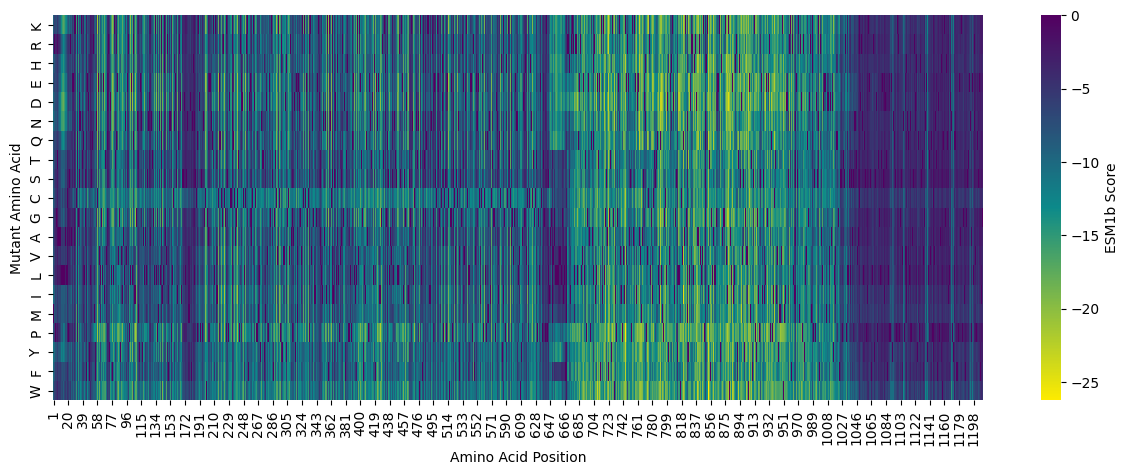

In [18]:
df_tidy_pandas = (
    df_tidy
    .to_pandas()
    .set_index("mut_aa")
)

custom_cmap = LinearSegmentedColormap.from_list(
    "custom_cmap", 
    ['#fdeb00', '#0c8a8a', '#530061']  # Yellow, Orange, Red
)
plt.figure(figsize=(15, 5))
sns.heatmap(df_tidy_pandas, annot=False, cmap=custom_cmap, cbar_kws={'label': 'ESM1b Score'}, vmax=0)
plt.xlabel("Amino Acid Position")
plt.ylabel("Mutant Amino Acid")
plt.savefig("../figures/egfr_esm1b.png", dpi=1000, bbox_inches='tight')  # Adjust dpi and bounding box for quality and fit
plt.show()